# Random Forest

This notebook will be used to tune and evaluate the Random Forest model.

We will tune the model hyperparameters using crossvalidation, using two different scores: balanced_accuracy and f1_weighted. We also have a variable 'noise_event_laeq_primary_detected_certainty' which accounts for how certain it is that a noise was labeled correctly. We will consider models with and without these variable. 

Therefore, we need to tune and evaluate four different cases:
- certainty + balanced_accuracy
- certainty + f1_weighted
- no certainty + balanced_accuracy
- no certainty + f1_weighted

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, balanced_accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.model_datatransforms import *

---
# Data Loading

In [3]:
df = pd.read_parquet('data/pred_model_data_full.parquet')

In [4]:
df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Unsupported                       20791
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Music non-amplified                 126
Nature elements - Wind              113
Name: noise_event_laeq_primary_detected_class, dtype: int64

In [5]:
conditions = df['noise_event_laeq_primary_detected_class'].isin(['Music non-amplified', 'Nature elements - Wind', 'Unsupported'])
df.loc[conditions, 'noise_event_laeq_primary_detected_class'] = 'Other'

df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Other                             21030
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Name: noise_event_laeq_primary_detected_class, dtype: int64

In [6]:
X = df.drop(columns=['noise_event_laeq_primary_detected_class'])

le = LabelEncoder()
y = le.fit_transform(df[['noise_event_laeq_primary_detected_class']])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

c:\Users\Federico\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Convert 'noise_event_laeq_primary_detected_certainty' to values between 0 and 1

In [7]:
X['noise_event_laeq_primary_detected_certainty']=X['noise_event_laeq_primary_detected_certainty']/100
X.noise_event_laeq_primary_detected_certainty

0        0.97
1        0.78
2        0.98
3        1.00
4        1.00
         ... 
77227    0.96
77228    0.98
77229    0.85
77230    0.00
77231    0.00
Name: noise_event_laeq_primary_detected_certainty, Length: 77232, dtype: float64

---
# Certainty + balanced_accuracy

In [14]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'])
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('randomForest', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [15]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='balanced_accuracy', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.6365759177677354

In [16]:
n_estimators = np.arange(250, 450, 50) # number of trees in the random forest
max_depth = np.arange(10,19,3) # maximum number of levels allowed in each decision tree
min_samples_split = np.arange(45,70,5) # minimum sample number to split a node
ccp_alpha = np.array([1e-7, 1e-5, 1e-3])

random_grid = {
    'month_handler__strategy': ['month'], #'season'
    'day_of_the_week_handler__strategy': ['full'], #'weekend'
     'custom_encoder__strategy': ['one_hot'], #, 'binary'
    'randomForest__n_estimators': n_estimators,
    'randomForest__max_depth': max_depth,
    'randomForest__min_samples_split': min_samples_split,
    'randomForest__ccp_alpha': ccp_alpha   
}

In [17]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = RandomizedSearchCV(pipeline, param_distributions=random_grid, n_jobs=-1, cv=cv, n_iter=100, scoring='balanced_accuracy')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

Best Score: 0.8060286390158313
Best Parameters: {'randomForest__n_estimators': 350, 'randomForest__min_samples_split': 60, 'randomForest__max_depth': 13, 'randomForest__ccp_alpha': 1e-05, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [20]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('randomForest', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=350, min_samples_split=60, max_depth=13, ccp_alpha=1e-05))
])

In [21]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_id', 'day_period', 'month',
                                        'weekday'])),
                ('pca',
                 PC...
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                         'lamax_shift_t-_5', 'laeq_shift_t-_5',
                                         'lceq_shift_t-_5',
                                         'lcpeak_shift_t-_5'],
                                n_components=7)),
                ('randomForest',
                 RandomForestClassifier(ccp_alpha=1e-05,
                                        class_weight='balanced', max_depth=13,
                                        min_samples_split=60, n_estimators=350,
                                        random_state=42))])

In [22]:
y_pred = pipeline.predict(X_test)

In [23]:
y_pred_proba = pipeline.predict_proba(X_test)

In [24]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.9013379369874838
Balanced Accuracy: 0.8020387287955051


In [25]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.9637082555992628

In [26]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

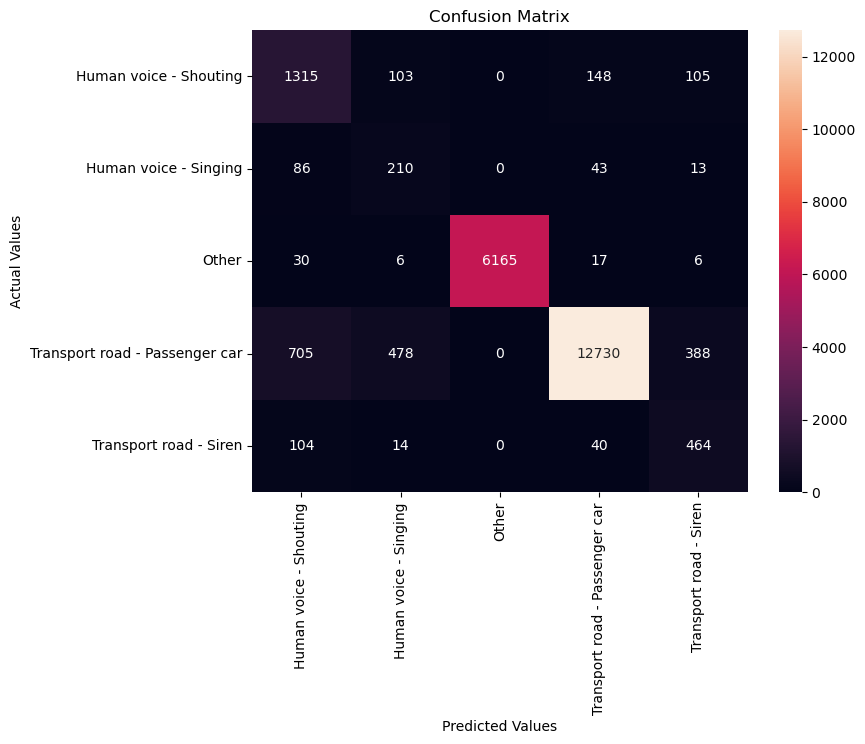

In [27]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

In [28]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.59      0.79      0.67      1671
         Human voice - Singing       0.26      0.60      0.36       352
                         Other       1.00      0.99      1.00      6224
Transport road - Passenger car       0.98      0.89      0.93     14301
        Transport road - Siren       0.48      0.75      0.58       622

                      accuracy                           0.90     23170
                     macro avg       0.66      0.80      0.71     23170
                  weighted avg       0.93      0.90      0.91     23170



---
# Certainty + f1_weighted

In [52]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'])
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('randomForest', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [53]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.9405759267574693

In [54]:
n_estimators = np.arange(400, 550, 50) # number of trees in the random forest
max_depth = np.arange(17,25,3) # maximum number of levels allowed in each decision tree
min_samples_split = np.arange(15,30,5) # minimum sample number to split a node
ccp_alpha = np.array([0, 1e-13, 1e-11])

random_grid = {
    'month_handler__strategy': ['month'], #'season'
    'day_of_the_week_handler__strategy': ['full'], #'weekend'
    'custom_encoder__strategy': ['one_hot'], #, 'binary'
    'randomForest__n_estimators': n_estimators,
    'randomForest__max_depth': max_depth,
    'randomForest__min_samples_split': min_samples_split,
    'randomForest__ccp_alpha': ccp_alpha   
}

In [55]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = RandomizedSearchCV(pipeline, param_distributions=random_grid, n_jobs=-1, cv=cv, n_iter=600, scoring='f1_weighted')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
#print("Best Estimator:", search.best_estimator_)
print("Best Parameters:", search.best_params_)

c:\Users\anaso\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 81 is smaller than n_iter=600. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Score: 0.9424389430079224
Best Parameters: {'randomForest__n_estimators': 500, 'randomForest__min_samples_split': 15, 'randomForest__max_depth': 20, 'randomForest__ccp_alpha': 1e-13, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [56]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'])
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('randomForest', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=500, min_samples_split=15, max_depth=20, ccp_alpha=1e-13))
])

In [57]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_id', 'day_period', 'month',
                                        'weekday'])),
                ('pca',
                 PC...
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                         'lamax_shift_t-_5', 'laeq_shift_t-_5',
                                       

In [58]:
y_pred = pipeline.predict(X_test)

In [59]:
y_pred_proba = pipeline.predict_proba(X_test)

In [60]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.9434613724643937
Balanced Accuracy: 0.7649341486293209


In [61]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.966181768098181

In [62]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

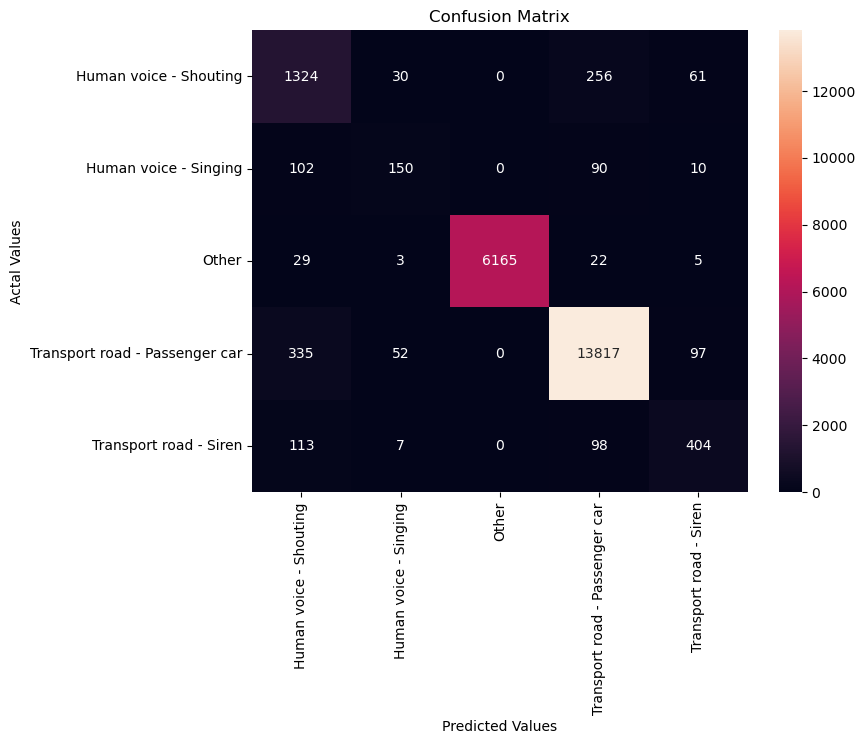

In [63]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

In [64]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.70      0.79      0.74      1671
         Human voice - Singing       0.62      0.43      0.51       352
                         Other       1.00      0.99      1.00      6224
Transport road - Passenger car       0.97      0.97      0.97     14301
        Transport road - Siren       0.70      0.65      0.67       622

                      accuracy                           0.94     23170
                     macro avg       0.80      0.76      0.78     23170
                  weighted avg       0.94      0.94      0.94     23170



---
# No certainty + balanced_accuracy

In [100]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'])
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('randomForest', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [101]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='balanced_accuracy', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.617005061663432

In [102]:
n_estimators = np.arange(400, 550, 50) # number of trees in the random forest
max_depth = np.arange(10,18,3) # maximum number of levels allowed in each decision tree
min_samples_split = np.arange(18,30,3) # minimum sample number to split a node
ccp_alpha = np.array([1e-11, 1e-9, 1e-7])

random_grid = {
    'month_handler__strategy': ['month'], #'season'
    'day_of_the_week_handler__strategy': ['full'], #'weekend'
    'custom_encoder__strategy': ['one_hot'], #, 'binary'
    'randomForest__n_estimators': n_estimators,
    'randomForest__max_depth': max_depth,
    'randomForest__min_samples_split': min_samples_split,
    'randomForest__ccp_alpha': ccp_alpha   
}

In [104]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = RandomizedSearchCV(pipeline, param_distributions=random_grid, n_jobs=-1, cv=cv, n_iter=108, scoring='balanced_accuracy')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
#print("Best Estimator:", search.best_estimator_)
print("Best Parameters:", search.best_params_)

Best Score: 0.620470692749183
Best Parameters: {'randomForest__n_estimators': 500, 'randomForest__min_samples_split': 27, 'randomForest__max_depth': 10, 'randomForest__ccp_alpha': 1e-11, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [105]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'])
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('randomForest', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=500, min_samples_split=27, max_depth=10, ccp_alpha=1e-11))
])

In [106]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id',
                                                'noise_event_laeq_primary_detected_certainty'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_i...
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                         'lamax_shift_t-_5', 'laeq_shift_t-_5',
                                         'lceq_shift_t-_5',
        

In [107]:
y_pred = pipeline.predict(X_test)

In [108]:
y_pred_proba = pipeline.predict_proba(X_test)

In [109]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.6600776866637894
Balanced Accuracy: 0.622953597716341


In [110]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.8812895254876508

In [111]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

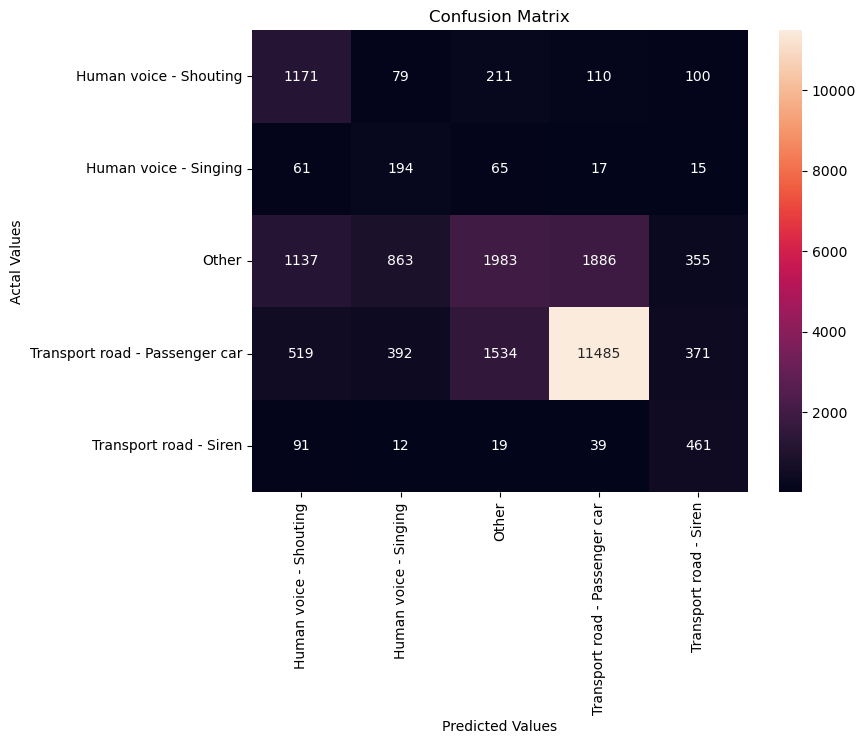

In [112]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

In [113]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.39      0.70      0.50      1671
         Human voice - Singing       0.13      0.55      0.21       352
                         Other       0.52      0.32      0.40      6224
Transport road - Passenger car       0.85      0.80      0.83     14301
        Transport road - Siren       0.35      0.74      0.48       622

                      accuracy                           0.66     23170
                     macro avg       0.45      0.62      0.48     23170
                  weighted avg       0.70      0.66      0.67     23170



---
# No certainty + f1_weighted

In [55]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'])
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('randomForest', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [56]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.6144985406518084

In [57]:
n_estimators = np.arange(300, 500, 50) # number of trees in the random forest
max_depth = np.arange(25,45,5) # maximum number of levels allowed in each decision tree
min_samples_split = np.arange(5,15,3) # minimum sample number to split a node
ccp_alpha = np.array([1e-11, 1e-9, 1e-7])

random_grid = {
    'month_handler__strategy': ['month'], #'season'
    'day_of_the_week_handler__strategy': ['full'], #'weekend'
    'custom_encoder__strategy': ['one_hot'], #, 'binary'
    'randomForest__n_estimators': n_estimators,
    'randomForest__max_depth': max_depth,
    'randomForest__min_samples_split': min_samples_split,
    'randomForest__ccp_alpha': ccp_alpha   
}

In [58]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = RandomizedSearchCV(pipeline, param_distributions=random_grid, n_jobs=-1, cv=cv, n_iter=150, scoring='f1_weighted')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
#print("Best Estimator:", search.best_estimator_)
print("Best Parameters:", search.best_params_)

Best Score: 0.7428675907245258
Best Parameters: {'randomForest__n_estimators': 350, 'randomForest__min_samples_split': 8, 'randomForest__max_depth': 30, 'randomForest__ccp_alpha': 1e-09, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [59]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'])
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('randomForest', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=350, min_samples_split=8, max_depth=30, ccp_alpha=1e-09))
])

In [60]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id',
                                                'noise_event_laeq_primary_detected_certainty'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_i...
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                         'lamax_shift_t-_5', 'laeq_shift_t-_5',
                                         'lceq_shift_t-_5',
        

In [61]:
y_pred = pipeline.predict(X_test)

In [62]:
y_pred_proba = pipeline.predict_proba(X_test)

In [63]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.7593439792835563
Balanced Accuracy: 0.5161539801674657


In [64]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.8767761234665205

In [65]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

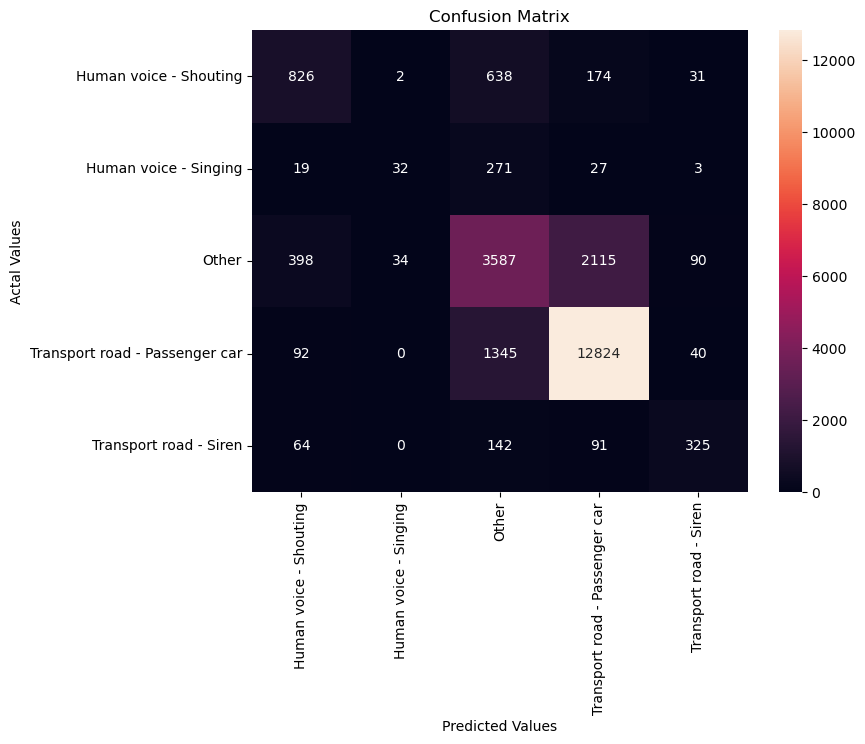

In [66]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

In [67]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.59      0.49      0.54      1671
         Human voice - Singing       0.47      0.09      0.15       352
                         Other       0.60      0.58      0.59      6224
Transport road - Passenger car       0.84      0.90      0.87     14301
        Transport road - Siren       0.66      0.52      0.59       622

                      accuracy                           0.76     23170
                     macro avg       0.63      0.52      0.55     23170
                  weighted avg       0.75      0.76      0.75     23170

